# Proyek Klasifikasi Gambar: [Garbage Classification]
- **Nama:** [Muhammad Fadel Hamka]
- **Email:** [faadelhamka123@gmail.com]
- **ID Dicoding:** [Muhammad Fadel Hamka]

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflow
!pip install tensorflowjs
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from glob import glob

## Data Preparation

### Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
base_dir   = "/content/drive/MyDrive/Dataset Garbage/Garbage classification/Garbage classification"
split_root = "/content/garbage_split"

# Ambil daftar kelas
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

classes

['paper', 'cardboard', 'glass', 'metal', 'plastic', 'trash']

### Data Preprocessing

#### Split Dataset

In [4]:
# === Pilih 3 Kelas Terbaik ===
all_classes = ['cardboard','paper','plastic','glass','metal','trash']
support_counts = {}
for cls in all_classes:
    support_counts[cls] = len(glob(f"/content/garbage_split/train/{cls}/*"))
top3 = [cls for cls,_ in sorted(support_counts.items(), key=lambda x: x[1], reverse=True)][:3]
print("Selected classes:", top3)

Selected classes: ['cardboard', 'paper', 'plastic']


In [5]:
# 1) Path ke dataset asli
base_orig = "/content/drive/MyDrive/Dataset Garbage/Garbage classification/Garbage classification"
top3 = ['cardboard','paper','plastic']

data_paths, data_labels = [], []
for cls in top3:
    cls_dir = os.path.join(base_orig, cls)
    imgs = glob(os.path.join(cls_dir, "*.jpg"))
    imgs += glob(os.path.join(cls_dir, "*.jpeg"))
    imgs += glob(os.path.join(cls_dir, "*.png"))
    print(f"{cls}: {len(imgs)} images")
    data_paths += imgs
    data_labels += [cls]*len(imgs)
print("Total images for top3:", len(data_paths))

# Stratified split 70/15/15
train_p, temp_p, train_l, temp_l = train_test_split(
    data_paths, data_labels,
    stratify=data_labels,
    test_size=0.30,
    random_state=42
)
val_p, test_p, val_l, test_l = train_test_split(
    temp_p, temp_l,
    stratify=temp_l,
    test_size=0.50,
    random_state=42
)

new_root = "/content/garbage_3cls"
for split in ['train','val','test']:
    for cls in top3:
        os.makedirs(os.path.join(new_root, split, cls), exist_ok=True)

def copy_split(paths, labels, split):
    for src, lbl in zip(paths, labels):
        dst = os.path.join(new_root, split, lbl, os.path.basename(src))
        shutil.copy2(src, dst)

copy_split(train_p, train_l, 'train')
copy_split(val_p,   val_l,   'val')
copy_split(test_p,  test_l,  'test')
print("Split 3-class dataset selesai.")

cardboard: 403 images
paper: 594 images
plastic: 482 images
Total images for top3: 1479
Split 3-class dataset selesai.


In [6]:
# === Paths ===
train_dir = "/content/garbage_3cls/train"
val_dir   = "/content/garbage_3cls/val"
test_dir  = "/content/garbage_3cls/test"
num_classes = 3

## Modelling

In [7]:
# === Data Generators ===
train_dir = new_root + '/train'
val_dir   = new_root + '/val'
test_dir  = new_root + '/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    zoom_range=0.15,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224,224), batch_size=32,
    class_mode='categorical', shuffle=False
)

num_classes = 3

Found 1035 images belonging to 3 classes.
Found 222 images belonging to 3 classes.
Found 222 images belonging to 3 classes.


In [8]:
# === Build Sequential Model ===
model=Sequential([
    InputLayer(input_shape=(224,224,3)),
    Conv2D(32,(3,3),activation='relu',padding='same'), MaxPooling2D(),
    Conv2D(64,(3,3),activation='relu',padding='same'), MaxPooling2D(),
    Conv2D(128,(3,3),activation='relu',padding='same'), MaxPooling2D(),
    Flatten(), Dense(128,activation='relu'), Dropout(0.3),
    Dense(num_classes,activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# === Callbacks ===
early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history=model.fit(train_gen, epochs=30, validation_data=val_gen, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.3712 - loss: 1.5657 - val_accuracy: 0.5541 - val_loss: 0.8317
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.5990 - loss: 0.8711 - val_accuracy: 0.6892 - val_loss: 0.7311
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.6175 - loss: 0.8601 - val_accuracy: 0.6802 - val_loss: 0.7306
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.6887 - loss: 0.6960 - val_accuracy: 0.7027 - val_loss: 0.6562
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.7421 - loss: 0.6669 - val_accuracy: 0.8108 - val_loss: 0.5938
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - accuracy: 0.7461 - loss: 0.6171 - val_accuracy: 0.8063 - val_loss: 0.5404
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.7440 - loss: 0.6372 - val_accuracy: 0.8288 - val_loss: 0.5192
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.7997 - loss: 0.5284 - val_accuracy: 0.7748 - v

## Evaluasi dan Visualisasi

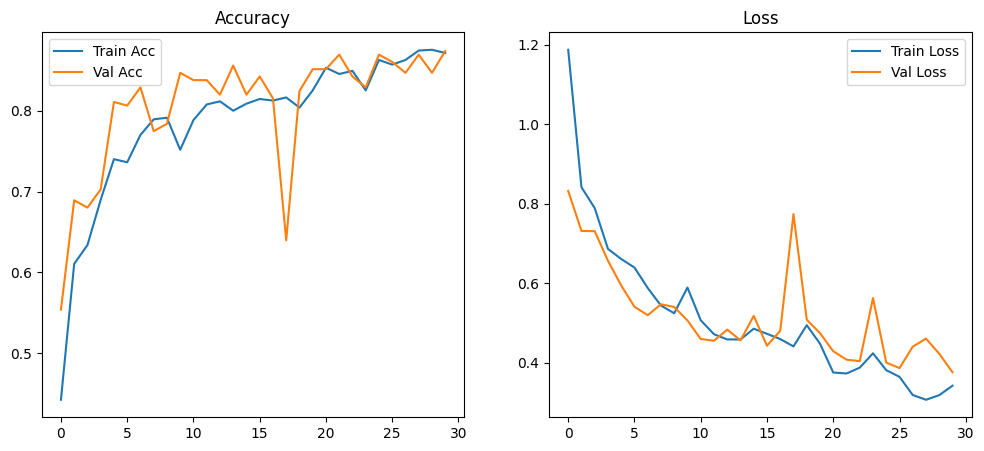

In [10]:
# ===  Plot Accuracy & Loss ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Acc')
plt.plot(history.history['val_accuracy'],label='Val Acc')
plt.title('Accuracy');plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.title('Loss');plt.legend()
plt.show()

In [11]:
# === Evaluate on Test Set ===
loss,acc=model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.2f}%")
y_pred=model.predict(test_gen)
y_pred_cls=np.argmax(y_pred,axis=1)
print(classification_report(test_gen.classes,y_pred_cls,target_names=top3))

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8872 - loss: 0.2877
Test Accuracy: 86.49%
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
              precision    recall  f1-score   support

   cardboard       0.89      0.90      0.89        61
       paper       0.86      0.90      0.88        89
     plastic       0.85      0.79      0.82        72

    accuracy                           0.86       222
   macro avg       0.87      0.86      0.86       222
weighted avg       0.86      0.86      0.86       222



## Konversi Model

In [12]:
# === Save final model formats ===
# 1. SavedModel
os.makedirs('submission/saved_model',exist_ok=True)
tf.saved_model.save(model,'submission/saved_model')

In [13]:
# 2. TFLite
converter=tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model=converter.convert()
os.makedirs('submission/tflite',exist_ok=True)
open('submission/tflite/model.tflite','wb').write(tflite_model)
open('submission/tflite/label.txt','w').write('\n'.join(top3))

23

In [14]:
# 3. TFJS
os.system('pip install tensorflowjs --quiet')
os.system('tensorflowjs_converter --input_format=tf_saved_model submission/saved_model submission/tfjs_model')

0

## Inference (Optional)

In [19]:
# 1) Load SavedModel
model = tf.saved_model.load('submission/saved_model')
infer = model.signatures['serving_default']

# 1.a) Lihat apa saja key di signature ini
print("Available output keys:", list(infer.structured_outputs.keys()))

# 2) Siapkan gambar
def preprocess(path):
    img = Image.open(path).resize((224,224))
    arr = np.array(img)/255.0
    return tf.constant(arr[np.newaxis, ...], dtype=tf.float32)

# 3) Inference
image_path = '/content/garbage_3cls/test/cardboard/cardboard1.jpg'
x = preprocess(image_path)

outputs = infer(x)

# 4) Ambil prediksi tanpa bergantung pada nama key
#    (jika hanya 1 output, kita bisa ambil .values()[0])
pred = list(outputs.values())[0]

cls  = tf.argmax(pred, axis=1).numpy()[0]
conf = tf.reduce_max(pred, axis=1).numpy()[0]

print(f'Prediksi: {top3[cls]} ({conf:.2f})')

Available output keys: ['output_0']
Prediksi: cardboard (0.99)
